<a href="https://colab.research.google.com/github/JorgeLastraCerda/JorgeLastraCerda.github.io/blob/master/Analysis_of_Chilean_Legislative_Speeches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis of Chilean Legislative Speeches**

This project analyzes speeches made by Chilean political representatives as transcribed by the Biblioteca Nacional del Congreso (BCN).

## Libraries

In [2]:
!pip install requests pandas numpy matplotlib seaborn beautifulsoup4 unidecode nltk scikit-learn PyPDF2 spacy spacytextblob
!python -m spacy download es_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.17.1
    Uninstalling textblob-0.17.1:
      Successfully uninstalled textblob-0.17.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 76.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
!pip install --upgrade patsy

In [4]:
import requests
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
from unidecode import unidecode
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import PyPDF2
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
import seaborn as sns

In [5]:
import seaborn as sns

## Scraping the Deputies' information:


Scrape the main page of the [Chilean Cámara de Diputados](https://www.camara.cl/diputados/diputados.aspx#mostrarDiputados) to extract the names and URLs of each deputy. This will provide a list of political representatives whose speeches we will later analyze.

Visit each deputy's individual page and scrape additional information such as their political party (Partido), district (Distrito), municipality (Comuna), and parliamentary group (Bancada). This metadata will be used to enrich the analysis of their speeches.

Also create the political coalitions:
*   Guberment coalition (Alianza de Gobierno)
*   Other left parties (Partido Humanista)
*   Center (Centro)
*   Center-right wing coalition (Chile Vamos)
*   Right wing (Derecha)

* Independents still have to be classified for coalitions

In [6]:
def clean_name(name):
    prefixes = ["Diputado", "Diputada", "Sr.", "Sra.", "Srta."]
    for prefix in prefixes:
        if prefix in name:
            name = name.replace(prefix, "").strip()
    return name

def normalize_url(url):
    base_url = "https://www.camara.cl"
    if url.startswith("/"):
        url = base_url + url
    elif not url.startswith("http"):
        url = base_url + "/" + url
    if '/diputados/' not in url:
        url = url.replace("/detalle/", "/diputados/detalle/")
    return url

def fetch_page(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return BeautifulSoup(response.content, 'html.parser')
    except requests.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

def extract_deputy_links(soup):
    return soup.find_all('a', href=lambda x: x and 'detalle/mociones.aspx' in x)

def scrape_deputy_profile(deputy):
    soup = fetch_page(deputy['URL'])
    if not soup:
        return deputy

    name_tag = soup.find('h1', class_='rotulo') or soup.find('h2', class_='rotulo')
    if name_tag:
        deputy['Full Name'] = clean_name(name_tag.text.strip())

    info_div = soup.find('div', class_='grid-3 aleft m-left14', style='margin-right: 20px;')
    if info_div:
        info_text = info_div.get_text(strip=True)

        patterns = {
            'Comunas': r'Comunas:\s*(.*?)(?=Distrito|$)',
            'Distrito': r'Distrito:\s*(.*?)(?=Región|$)',
            'Región': r'Región:\s*(.*?)(?=Período|$)',
            'Período': r'Período:\s*(.*?)(?=Partido|$)',
            'Partido': r'Partido:\s*(.*?)(?=Bancada|$)',
            'Bancada': r'Bancada:\s*(.*?)(?=$)'
        }

        for key, pattern in patterns.items():
            match = re.search(pattern, info_text)
            if match:
                deputy[key] = match.group(1).strip()

    return deputy

def scrape_deputies_main_page(url):
    soup = fetch_page(url)
    if not soup:
        return []

    deputies = extract_deputy_links(soup)
    deputy_list = [{'Name': clean_name(d.text.strip()), 'URL': normalize_url(d['href'])} for d in deputies if d.text.strip()]
    return list({d['URL']: d for d in deputy_list}.values())  # Remove duplicates

def main():
    main_url = "https://www.camara.cl/diputados/diputados.aspx#mostrarDiputados"
    deputies = scrape_deputies_main_page(main_url)
    print(f"Found {len(deputies)} unique deputies")

    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_deputy = {executor.submit(scrape_deputy_profile, deputy): deputy for deputy in deputies}
        for future in as_completed(future_to_deputy):
            deputy = future_to_deputy[future]
            try:
                data = future.result()
                print(f"Scraped data for: {data.get('Full Name', data['Name'])}")
            except Exception as exc:
                print(f"{deputy['Name']} generated an exception: {exc}")

    df = pd.DataFrame(deputies)

    # Save to CSV
    df.to_csv('chilean_deputies_raw.csv', index=False)
    print("Raw data saved to chilean_deputies_raw.csv")

    return df  # Return the DataFrame

if __name__ == "__main__":
    df_deputies = main()

Found 155 unique deputies
Scraped data for: Mónica Arce Castro
Scraped data for: María Candelaria Acevedo Sáez
Scraped data for: Cristián Araya Lerdo de Tejada
Scraped data for: René Alinco Bustos
Scraped data for: Eric Aedo Jeldres
Scraped data for: Karol Cariola Oliva
Scraped data for: Gaspar Rivas Sánchez
Scraped data for: Jorge Alessandri Vergara
Scraped data for: Jaime Araya Guerrero
Scraped data for: Danisa Astudillo Peiretti
Scraped data for: Yovana Ahumada Palma
Scraped data for: Roberto Arroyo Muñoz
Scraped data for: Boris Barrera Moreno
Scraped data for: Sergio Bobadilla Muñoz
Scraped data for: Chiara Barchiesi Chávez
Scraped data for: Miguel Ángel Becker Alvear
Scraped data for: Juan Carlos Beltrán Silva
Scraped data for: María Francisca Bello Campos
Scraped data for: Gustavo Benavente Vergara
Scraped data for: Héctor Barría Angulo
Scraped data for: Alejandro Bernales Maldonado
Scraped data for: Bernardo Berger Fett
Scraped data for: Carlos Bianchi Chelech
Scraped data for: 

Independientes:

In [7]:
def analyze_independents(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Count total number of deputies
    total_deputies = len(df)

    # Filter independents
    independents = df[df['Partido'] == 'Independientes']

    # Count independents
    total_independents = len(independents)

    # Count independents with a bancada
    independents_with_bancada = independents[independents['Bancada'].notna() & (independents['Bancada'] != '')]
    total_independents_with_bancada = len(independents_with_bancada)

    # Print results
    print(f"Total number of deputies: {total_deputies}")
    print(f"Total number of independents: {total_independents}")
    print(f"Number of independents with a bancada: {total_independents_with_bancada}")

    # Print percentage of independents
    percentage_independents = (total_independents / total_deputies) * 100
    print(f"Percentage of independents: {percentage_independents:.2f}%")

    # Print percentage of independents with bancada
    percentage_with_bancada = (total_independents_with_bancada / total_independents) * 100 if total_independents > 0 else 0
    print(f"Percentage of independents with a bancada: {percentage_with_bancada:.2f}%")

    # List independents and their bancadas
    print("\nList of independents and their bancadas:")
    for _, deputy in independents.iterrows():
        bancada = deputy['Bancada'] if pd.notna(deputy['Bancada']) else 'No bancada'
        print(f"{deputy['Full Name']}: {bancada}")

    # Count independents by bancada
    bancada_counts = independents['Bancada'].value_counts()
    print("\nDistribution of independents across bancadas:")
    print(bancada_counts)

if __name__ == "__main__":
    csv_file = 'chilean_deputies_raw.csv'  # Make sure this matches your CSV file name
    analyze_independents(csv_file)

Total number of deputies: 155
Total number of independents: 41
Number of independents with a bancada: 39
Percentage of independents: 26.45%
Percentage of independents with a bancada: 95.12%

List of independents and their bancadas:
Gaspar Rivas Sánchez: No bancada
Yovana Ahumada Palma: Comité Social Cristiano e Independientes
René Alinco Bustos: Comité Independientes
Jaime Araya Guerrero: Partido Por la Democracia
Mónica Arce Castro: Comité DC e Independientes
Bernardo Berger Fett: Renovación Nacional
Carlos Bianchi Chelech: Partido Por la Democracia
Miguel Ángel Calisto Águila: Comité Demócratas, Amarillos e Independientes
Felipe Camaño Cárdenas: Comité DC e Independientes
Sofía Cid Versalovic: Comité Republicanos
María Luisa Cordero Velásquez: Renovación Nacional
Gonzalo De la Carrera Correa: Comité Social Cristiano e Independientes
Catalina Del Real Mihovilovic: Comité Republicanos
Viviana Delgado Riquelme: Comité Mixto Radical - Liberal
Félix González Gatica: Frente Amplio e Indepe

Classification by parties and bancadas (for independents)

In [8]:
def categorize_party_and_bancada(row):
    party = row['Partido']
    bancada = row['Bancada']

    alianza_gobierno = [
        "Partido Comunista", "Partido Por la Democracia", "Partido Socialista",
        "Frente Amplio", "Partido Liberal de Chile", "Partido Acción Humanista",
        "Partido Radical de Chile", "Federación Regionalista Verde Social"
    ]
    center_right = ["Renovación Nacional", "Evolución Política"]
    right_wing = ["Unión Demócrata Independiente", "Partido Republicano", "Partido Social Cristiano"]
    center = ["Partido Demócrata Cristiano", "Movimiento Amarillos por Chile", "Partido Demócratas Chile"]

    # Classify based on party
    if party in alianza_gobierno:
        return "Alianza de Gobierno"
    elif party in center_right:
        return "Center-Right"
    elif party in right_wing:
        return "Right Wing"
    elif party in center:
        return "Center"

    # If independent, classify based on bancada
    if party == "Independientes":
        bancada_classifications = {
            "Partido Por la Democracia": "Alianza de Gobierno",
            "Comité Republicanos": "Right Wing",
            "Comité Demócratas, Amarillos e Independientes": "Center",
            "Renovación Nacional": "Center-Right",
            "Comité Social Cristiano e Independientes": "Right Wing",
            "Comité DC e Independientes": "Center",
            "Frente Amplio e Independientes": "Alianza de Gobierno",
            "Comité Mixto Radical - Liberal": "Alianza de Gobierno",
            "Evolución Política": "Center-Right",
            "Unión Demócrata Independiente": "Right Wing",
            "Socialista": "Alianza de Gobierno",
            "Comité Comunista, Federación Regionalista Verde Social, Acción Humanista e Independientes": "Alianza de Gobierno"
        }
        return bancada_classifications.get(bancada, "Unknown")

    return "Unknown"

def classify_deputies(df):
    df['Political_Category'] = df.apply(categorize_party_and_bancada, axis=1)

    # Save classified data to CSV
    df.to_csv('chilean_deputies_classified.csv', index=False)
    print("Classified data saved to chilean_deputies_classified.csv")

    # Print category distribution
    print("\nDistribution of Political Categories:")
    print(df['Political_Category'].value_counts())

    # Check for unknown categories
    unknown_deputies = df[df['Political_Category'] == 'Unknown']
    if not unknown_deputies.empty:
        print("\nDeputies in the Unknown category:")
        for _, deputy in unknown_deputies.iterrows():
            print(f"Name: {deputy['Full Name']}, Party: {deputy['Partido']}, Bancada: {deputy['Bancada']}")
    else:
        print("\nNo deputies in the Unknown category.")

    return df

if __name__ == "__main__":
    # Load the raw data
    df_raw = pd.read_csv('chilean_deputies_raw.csv')
    df_classified = classify_deputies(df_raw)

Classified data saved to chilean_deputies_classified.csv

Distribution of Political Categories:
Political_Category
Alianza de Gobierno    66
Right Wing             42
Center-Right           26
Center                 15
Unknown                 6
Name: count, dtype: int64

Deputies in the Unknown category:
Name: Gaspar Rivas Sánchez, Party: Independientes, Bancada: nan
Name: René Alinco Bustos, Party: Independientes, Bancada: Comité Independientes
Name: Pamela Jiles Moreno, Party: Partido Humanista, Bancada: Comité Independientes
Name: Mauricio Ojeda Rebolledo, Party: Independientes, Bancada: nan
Name: Marisela Santibáñez Novoa, Party: Independientes, Bancada: Comité Independientes
Name: Mercedes Bulnes Núñez, Party: nan, Bancada: nan


## Extracting Speech Text from Transcriptions:

## Law Selection Script

This script allows users to choose between analyzing the default **Naín-Retamal Law** or another law by specifying a different Google Drive link.
By default, the script will use the Naín-Retamal Law for analysis. To switch to another law, simply replace the `selected_law_link` variable
with the Google Drive link of the other law's PDF.

### Pre-loaded Laws:
1. **Naín-Retamal Law** (Default):
   - Protects police forces and provides legal certainty for their actions in maintaining public order.
   - Google Drive Link: https://drive.google.com/file/d/1FCmXKFdPuT00pbMF-n2nUqISaWtY2GNc/view

2. **[Antiterrorist law]** (second option):
   - Explanation of the law
   - Google Drive Link: https://drive.google.com/file/d/1ljsDZeUmLYHJBYi7F_RNJ278PvPUm4m5

### How It Works:
- The script downloads the selected PDF, merges the required pages, and prepares it for further text analysis.

In [9]:
# Default and optional law links
nain_retamal_link = "https://drive.google.com/uc?id=1FCmXKFdPuT00pbMF-n2nUqISaWtY2GNc"
antiterrorist_link = "https://drive.google.com/uc?id=1ljsDZeUmLYHJBYi7F_RNJ278PvPUm4m5"

# User selection: By default, Naín-Retamal Law is selected
selected_law_link = antiterrorist_link  # Change this to `antiterrorist_link` for the alternative law

# File name for the downloaded law
output_pdf_path = "selected_law.pdf"


In [10]:
# Function to download the selected law
def download_law_file(google_drive_url, output_path):

    response = requests.get(google_drive_url)
    if response.status_code == 200:
        with open(output_path, 'wb') as file:
            file.write(response.content)
        print(f"Law successfully downloaded and saved as '{output_path}'.")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")

# Call the function to download the selected law
download_law_file(selected_law_link, output_pdf_path)

Law successfully downloaded and saved as 'selected_law.pdf'.


### Preprocessing of the pdfs

### Extraction and cleaning of speeches

Extract and clean this text, assigning each segment to the appropriate speaker based on metadata (names, titles, or roles) present in the transcription.

In [11]:
def clean_text(text):
    # Remove the header and the bcn.cl text
    patterns_to_remove = [
        r"Historia de la Ley N° 21\.560\s*Página\s*\d+\s*de\s*\d+\s*Discusión en Sala",
        r"Biblioteca del Congreso Nacional de Chile - www\.bcn\.cl/historiadelaley - documento generado el \d+-\w+-\d+"
    ]


    for pattern in patterns_to_remove:
        text = re.sub(pattern, "", text)

    return text.strip()

def extract_speech_text(pdf_path):
    speeches = []
    current_speaker = ""
    current_speech = ""
    total_text = ""

    try:
        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            total_pages = len(reader.pages)

            print(f"Total pages in PDF: {total_pages}")
            print(f"Analyzing all pages")

            for page_num in range(total_pages):
                if page_num % 10 == 0:  # Print progress every 10 pages
                    print(f"Processing page {page_num + 1}")

                page = reader.pages[page_num]
                text = page.extract_text()
                if text:
                    text = clean_text(text)
                    total_text += text + "\n\n"  # Add page breaks for clarity

                    # Split the text into lines
                    lines = text.split('\n')

                    for line in lines:
                        # Check if this line indicates a new speaker
                        speaker_match = re.search(r'(El señor|La señora|La señorita) ([^\.]+)', line)
                        if speaker_match:
                            # If we have a previous speech, save it
                            if current_speaker and current_speech:
                                speeches.append((current_speaker, current_speech.strip()))

                            # Start a new speech
                            current_speaker = speaker_match.group(0)
                            current_speech = line[speaker_match.end():].strip()
                        else:
                            # Add this line to the current speech
                            current_speech += " " + line.strip()

            # Don't forget to add the last speech
            if current_speaker and current_speech:
                speeches.append((current_speaker, current_speech.strip()))

        print(f"Total characters extracted: {len(total_text)}")
        print(f"First 500 characters of extracted text:\n{total_text[:500]}")

        return speeches, total_text

    except Exception as e:
        print(f"An error occurred while reading the PDF: {str(e)}")
        return [], ""

def save_speeches_to_csv(speeches, filename):
    with open(filename, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Speaker', 'Speech'])  # Write header
        for speaker, speech in speeches:
            writer.writerow([speaker, speech])
    print(f"Speeches saved to {filename}")

# Usage
pdf_path = "/content/selected_law.pdf"  # Replace with your PDF file path
extracted_speeches, total_text = extract_speech_text(pdf_path)

# Save speeches to CSV
csv_filename = "extracted_speeches.csv"
save_speeches_to_csv(extracted_speeches, csv_filename)

# Print the first few speeches
for speaker, speech in extracted_speeches[:5]:
    print(f"Speaker: {speaker}")
    print(f"Speech: {speech[:100]}...")  # Print first 100 characters of each speech
    print()

# Print total number of extracted speeches
print(f"Total speeches extracted: {len(extracted_speeches)}")


Total pages in PDF: 62
Analyzing all pages
Processing page 1
Processing page 11
Processing page 21
Processing page 31
Processing page 41
Processing page 51
Processing page 61
Total characters extracted: 214055
First 500 characters of extracted text:
Historia de la Ley N° 21.694
Modifica los cuerpos legales que indica para mejorar la persecución penal en materia
de reincidencia y delitos de mayor connotación social

Nota Explicativa 
Esta Historia de Ley ha sido construida por la Biblioteca del Congreso Nacional a partir de la información disponible
en sus archivos.
Se han incluido los distintos documentos de la tramitación legislativa, ordenados conforme su ocurrencia en cada
uno de los trámites del proceso de formación de la ley.
Se han om
Speeches saved to extracted_speeches.csv
Speaker: La señora HERTZ, doña Carmen (Vicepresidenta)
Speech: .- En el Orden del Día, corresponde continuar la discusión del proyecto de ley, iniciado en moción, ...

Speaker: La señora HERTZ, doña Carmen (V

### Cleaning of speaker column

In [12]:
def clean_speaker_name(speaker):
    # Initialize variables
    last_name = ""
    first_name = ""
    role = ""

    # Extract role if present
    role_match = re.search(r'\((presidente|presidenta|vicepresidente|vicepresidenta)\)', speaker, re.IGNORECASE)
    if role_match:
        role = role_match.group(1).capitalize()
        speaker = re.sub(r'\([^)]*\)', '', speaker).strip()

    # Extract last name and first name
    name_match = re.search(r'(El señor|La señora|La señorita)\s+([A-ZÁ-ÚÜ][A-ZÁ-ÚÜ\s]+)(?:\s*,?\s*(?:don|doña)\s+(\w+))?', speaker)
    if name_match:
        last_name = name_match.group(2).strip()
        first_name = name_match.group(3) if name_match.group(3) else ""

    # If first name wasn't found, look for it in parentheses
    if not first_name:
        first_name_match = re.search(r'\((?:don|doña)\s+(\w+)\)', speaker)
        if first_name_match:
            first_name = first_name_match.group(1)

    return last_name, first_name, role

def process_csv(input_file, output_file):
    with open(input_file, 'r', newline='', encoding='utf-8') as infile, \
         open(output_file, 'w', newline='', encoding='utf-8') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        # Write the header
        writer.writerow(['Last Name', 'First Name', 'Role', 'Speech'])

        # Skip the header of the input file
        next(reader)

        for row in reader:
            if len(row) >= 2:
                speaker, speech = row[0], row[1]
                last_name, first_name, role = clean_speaker_name(speaker)
                writer.writerow([last_name, first_name, role, speech])

    print(f"Processed speeches saved to {output_file}")

# Usage
input_csv = "extracted_speeches.csv"  # Your original CSV file
output_csv = "extracted_speeches_cleaned.csv"  # The new CSV file with cleaned data

process_csv(input_csv, output_csv)

# Print the first few rows of the output file to verify
print("\nFirst few rows of the cleaned data:")
with open(output_csv, 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0:  # Print header
            print("Last Name | First Name | Role | Speech (truncated)")
            print("-" * 60)
        else:  # Print data rows
            print(f"{row[0]:<10} | {row[1]:<11} | {row[2]:<4} | {row[3][:30]}...")
        if i >= 5:  # Print only the first 5 data rows
            break

Processed speeches saved to extracted_speeches_cleaned.csv

First few rows of the cleaned data:
Last Name | First Name | Role | Speech (truncated)
------------------------------------------------------------
HERTZ      | Carmen      | Vicepresidenta | .- En el Orden del Día, corres...
HERTZ      | Carmen      | Vicepresidenta | Tiene la palabra el diputado L...
SOTO       | Leonardo    |      | .- Señora Presidenta, la banca...
HERTZ      | Carmen      | Vicepresidenta | .- Tiene la palabra el diputad...
PULGAR     |             |      | .- Señora Presidenta, claramen...


In [13]:
# Load the cleaned speeches data
speeches_df = pd.read_csv('extracted_speeches_cleaned.csv')
print("Speeches DataFrame columns:")
print(speeches_df.columns)

# Load the Chilean deputies data
deputies_df = pd.read_csv('chilean_deputies_classified.csv')
print("\nDeputies DataFrame columns:")
print(deputies_df.columns)

# Function to calculate string similarity (simple version)
def string_similarity(s1, s2):
    s1, s2 = s1.lower(), s2.lower()
    return sum(a == b for a, b in zip(s1, s2)) / max(len(s1), len(s2))

# Function to find the best match for a speaker
def find_best_match(last_name, first_name):
    best_match = None
    best_score = 0

    for _, deputy in deputies_df.iterrows():
        # Adjust these column names based on the actual column names in your CSV
        deputy_last_name = deputy.get('Name', '').split()[-1]  # Assuming last name is the last part of 'Name'
        deputy_first_name = deputy.get('Name', '').split()[0]  # Assuming first name is the first part of 'Name'

        full_name = f"{deputy_last_name} {deputy_first_name}".strip()
        speaker_name = f"{last_name} {first_name}".strip()

        score = string_similarity(speaker_name, full_name)

        if score > best_score:
            best_score = score
            best_match = deputy

    if best_score >= 0.2:  # You can adjust this threshold
        return best_match
    else:
        return None

# Apply matching to the speeches dataframe
def match_speakers_to_deputies():
    matched_data = []

    for _, speech in speeches_df.iterrows():
        # Adjust these column names based on the actual column names in your CSV
        last_name = speech.get('Last Name', '')
        first_name = speech.get('First Name', '')

        match = find_best_match(last_name, first_name)

        if match is not None:
            matched_data.append({
                'Speech Last Name': last_name,
                'Speech First Name': first_name,
                'Speech Role': speech.get('Role', ''),
                'Matched Deputy': match.get('Name', ''),
                'Party': match.get('Partido', ''),
                'District': match.get('Distrito', ''),
                'Political Category': match.get('Political_Category', ''),
                'Speech': speech.get('Speech', '')
            })
        else:
            matched_data.append({
                'Speech Last Name': last_name,
                'Speech First Name': first_name,
                'Speech Role': speech.get('Role', ''),
                'Matched Deputy': 'No match found',
                'Party': '',
                'District': '',
                'Political Category': '',
                'Speech': speech.get('Speech', '')
            })

    return pd.DataFrame(matched_data)

# Perform the matching
matched_speeches = match_speakers_to_deputies()

# Save the matched data to a new CSV file
matched_speeches.to_csv('matched_speeches.csv', index=False)

# Print some statistics
print(f"\nTotal speeches: {len(matched_speeches)}")
print(f"Matched speeches: {len(matched_speeches[matched_speeches['Matched Deputy'] != 'No match found'])}")
print(f"Unmatched speeches: {len(matched_speeches[matched_speeches['Matched Deputy'] == 'No match found'])}")

# Print the first few rows of the matched data
print("\nFirst few rows of matched data:")
print(matched_speeches.head())

Speeches DataFrame columns:
Index(['Last Name', 'First Name', 'Role', 'Speech'], dtype='object')

Deputies DataFrame columns:
Index(['Name', 'URL', 'Full Name', 'Comunas', 'Distrito', 'Región', 'Período',
       'Partido', 'Bancada', 'Political_Category'],
      dtype='object')

Total speeches: 128
Matched speeches: 128
Unmatched speeches: 0

First few rows of matched data:
  Speech Last Name Speech First Name     Speech Role    Matched Deputy  \
0            HERTZ            Carmen  Vicepresidenta      Carmen Hertz   
1            HERTZ            Carmen  Vicepresidenta      Carmen Hertz   
2             SOTO          Leonardo             NaN     Leonardo Soto   
3            HERTZ            Carmen  Vicepresidenta      Carmen Hertz   
4           PULGAR               NaN             NaN  Francisco Pulgar   

                Party District   Political Category  \
0   Partido Comunista     Nº 8  Alianza de Gobierno   
1   Partido Comunista     Nº 8  Alianza de Gobierno   
2  Partido So

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Total number of speeches: 128
Number of unique speakers: 36

Top 10 speakers by number of speeches:
Speaker
El señor CIFUENTES (Presidente)                           50
La señora HERTZ, doña Carmen (Vicepresidenta)             18
El señor RIVAS (Vicepresidente)                           12
El señor LEIVA                                             4
La señorita CICARDINI , doña Daniella (Vicepresidenta)     4
El señor LONGTON                                           4
El señor LANDEROS (Secretario)                             3
La señorita CARIOLA , doña Karol (Presidenta)              3
El señor KAISER                                            2
El señor MIROSEVIC (Presidente accidental)                 2
Name: count, dtype: int64

Top 20 most common words:
[('ley', 161), ('proyecto', 148), ('penal', 126), ('artículo', 107), ('delitos', 81), ('n', 81), ('discusión', 72), ('sala', 65), ('comisión', 64), ('soto', 64), ('camila', 63), ('daniel', 63), ('ramírez', 63), ('sistema', 62), (

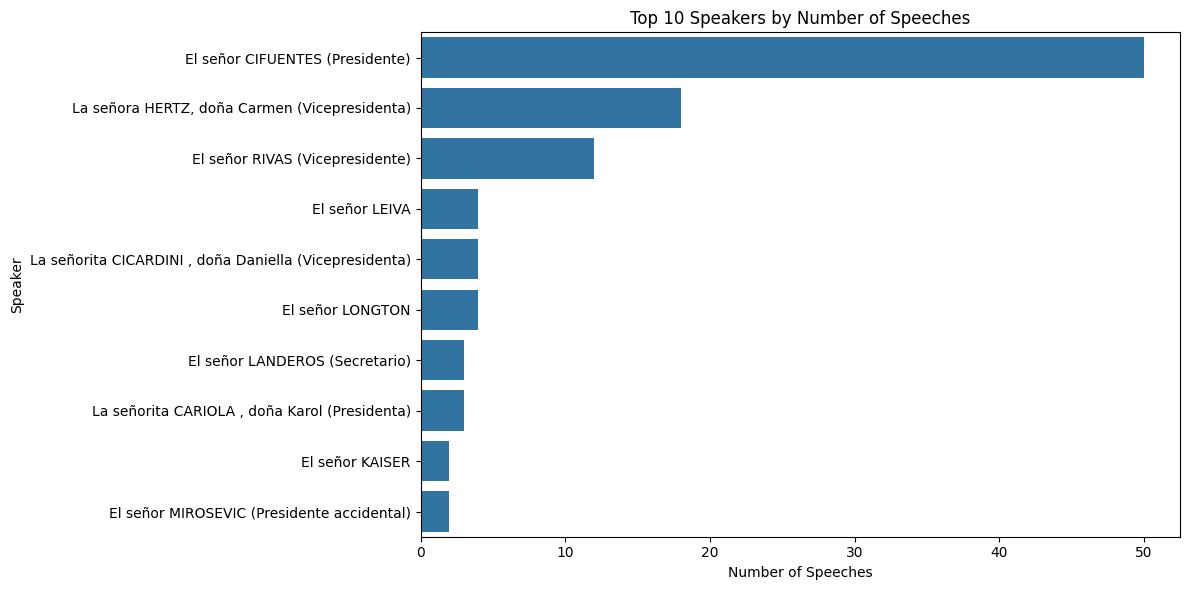

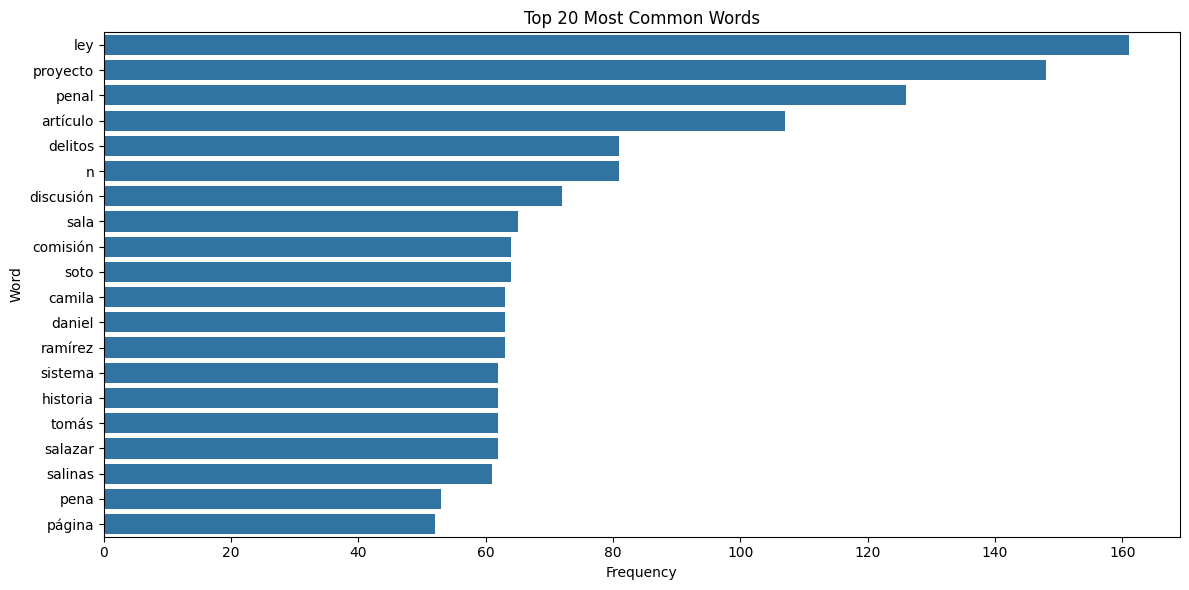


Analysis complete. Check 'top_speakers.png' and 'top_words.png' for visualizations.


In [14]:
# Download Spanish stopwords
nltk.download('stopwords')

# Read the CSV file
df = pd.read_csv("extracted_speeches.csv")

# Get Spanish stop words and add more names/common words
additional_stop_words = {'jorge', 'diputado', 'juan', 'palabra', 'maría', 'martínez', 'jaime', 'miguel', 'castro', 'pérez', 'señor', 'señora', 'gonzález', 'andrés', 'muñoz', 'castillo', 'luis', 'araya', 'sáez', 'moreno', 'romero', 'votación'}
spanish_stop_words = set(stopwords.words('spanish')).union(additional_stop_words)

# Text Preprocessing Function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('spanish'))
    words = text.split()
    words = [word for word in words if word not in spanish_stop_words]
    return ' '.join(words)

# Apply preprocessing to speeches
df['Processed_Speech'] = df['Speech'].apply(preprocess_text)

# Basic Analysis
print(f"Total number of speeches: {len(df)}")
print(f"Number of unique speakers: {df['Speaker'].nunique()}")

# Top 10 speakers by number of speeches
top_speakers = df['Speaker'].value_counts().head(10)
print("\nTop 10 speakers by number of speeches:")
print(top_speakers)

# Word frequency across all speeches
all_words = ' '.join(df['Processed_Speech']).split()
word_freq = Counter(all_words)
print("\nTop 20 most common words:")
print(word_freq.most_common(20))

# Visualize top speakers
plt.figure(figsize=(12, 6))
sns.barplot(x=top_speakers.values, y=top_speakers.index)
plt.title('Top 10 Speakers by Number of Speeches')
plt.xlabel('Number of Speeches')
plt.ylabel('Speaker')
plt.tight_layout()
plt.savefig('top_speakers.png')
plt.show()
plt.close()

# Visualize top words
top_words = dict(word_freq.most_common(20))
plt.figure(figsize=(12, 6))
sns.barplot(x=list(top_words.values()), y=list(top_words.keys()))
plt.title('Top 20 Most Common Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.savefig('top_words.png')
plt.show()
plt.close()

print("\nAnalysis complete. Check 'top_speakers.png' and 'top_words.png' for visualizations.")

In [15]:
extracted_speeches

[('La señora HERTZ, doña Carmen (Vicepresidenta)',
  '.- En el Orden del Día, corresponde continuar la discusión del proyecto de ley, iniciado en moción, que modifica diversos cuerpos legales con el objeto de mejorar la persecución penal, con énfasis en materia de reincidencia y en delitos de mayor connotación social, correspondiente al boletín N° 15661-07. Por acuerdo de los Comités, el plazo de inscripción para hacer uso de la palabra será de hasta treinta minutos después de iniciada la discusión y se votará con los que hayan intervenido, pudiendo insertar sus discursos quienes no alcancen a hacerlo. Para la discusión de este proyecto se otorgarán tres minutos a cada diputada y diputado que se inscriba para hacer uso de la palabra. Cabe a ser presente que el informe ya fue rendido. Antecedentes: -La discusión del proyecto de ley se inició en la sesión 141ª de la legislatura 371ª, en martes 5 de marzo de 2024, ocasión en que se rindió el informe de la Comisión de Constitución, Legisla

## Speech analysis


Analyze the extracted speeches to gain insights into topics discussed, speech frequency, length, and any relevant patterns.
Link these insights to the deputies’ metadata (party affiliation, region, etc.) to uncover trends or biases in the discussions.

### LDA

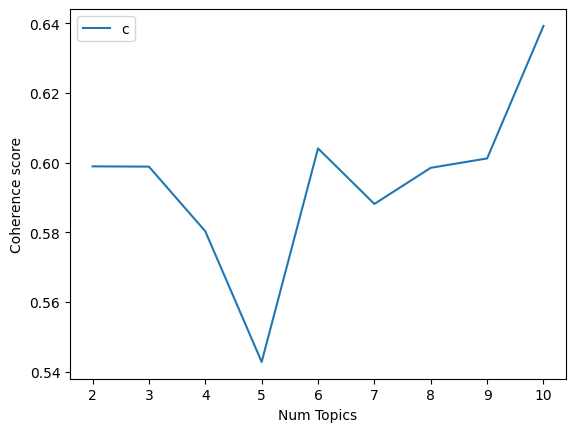

Num Topics = 2, Coherence Score = 0.598914252466616
Num Topics = 3, Coherence Score = 0.5988379713616635
Num Topics = 4, Coherence Score = 0.5802873331687831
Num Topics = 5, Coherence Score = 0.5427808403882846
Num Topics = 6, Coherence Score = 0.6040707481464046
Num Topics = 7, Coherence Score = 0.5881316535506805
Num Topics = 8, Coherence Score = 0.5985023411892681
Num Topics = 9, Coherence Score = 0.6011927540701966
Num Topics = 10, Coherence Score = 0.6392292368590984
Optimal number of topics: 10

Top 10 words for each topic:
Topic 1: ejecutivo, reserva, presidente, hace, lugar, artículo, constitucionalidad, atribuciones, obligado, mismo
Topic 2: artículo, ley, bis, artículos, código, inciso, penal, tribunal, siguiente, ter
Topic 3: ley, modificar, proyecto, penal, proceso, través, presidente, nuevos, condena, sido
Topic 4: así, proyecto, gente, personas, seguridad, vida, crimen, penal, recursos, izquierda
Topic 5: penal, proyecto, delitos, pena, ley, sistema, norma, crimen, si, ma

In [16]:
# Download Spanish stopwords
nltk.download('stopwords', quiet=True)

# Read the CSV file
df = pd.read_csv("extracted_speeches.csv")

# Get Spanish stop words and add more names/common words
additional_stop_words = {'jorge', 'diputado', 'juan', 'palabra', 'maría', 'martínez', 'jaime', 'miguel', 'castro', 'pérez', 'señor', 'señora', 'gonzález', 'andrés', 'muñoz', 'castillo', 'luis', 'araya', 'sáez', 'moreno', 'romero', 'votación'}
spanish_stop_words = set(stopwords.words('spanish')).union(additional_stop_words)

# Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    words = [word for word in words if word not in spanish_stop_words]
    return ' '.join(words)

# Apply preprocessing to speeches
df['Processed_Speech'] = df['Speech'].apply(preprocess_text)

# Combine all speeches into a single document for each speaker
df_combined = df.groupby('Speaker')['Processed_Speech'].apply(' '.join).reset_index()

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit+1, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15, iterations=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Prepare the data
texts = df_combined['Processed_Speech'].apply(lambda x: x.split()).tolist()
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

# Compute coherence values
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=10, step=1)

# Plot
limit=10; start=2; step=1;
x = range(start, limit+1, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print(f"Num Topics = {m}, Coherence Score = {cv}")

# Find the optimal number of topics
optimal_num_topics = x[coherence_values.index(max(coherence_values))]
print(f"Optimal number of topics: {optimal_num_topics}")

# Run LDA with optimal number of topics
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
doc_term_matrix = vectorizer.fit_transform(df_combined['Processed_Speech'])

lda_model = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=42, max_iter=100)
lda_output = lda_model.fit_transform(doc_term_matrix)

# Function to print top words for each topic
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

# Print the top 10 words for each topic
print("\nTop 10 words for each topic:")
print_topics(lda_model, vectorizer.get_feature_names_out(), 10)


Top 10 words for each topic:
Topic 1: proyecto, pena, penal, delitos, hoy, ley, va, años, hace, personas
Topic 2: ley, artículo, penal, proyecto, delitos, discusión, comisión, código, bis, artículos
Topic 3: artículo, votos, josé, vásquez, pino, lorena, afirmativa, sepúlveda, lillo, alejandro
Topic 4: proyecto, penal, ley, seguridad, delitos, dicho, sistema, crimen, materia, penas

Topic Distribution:
Dominant_Topic
3    0.555556
1    0.250000
0    0.138889
2    0.055556
Name: proportion, dtype: float64


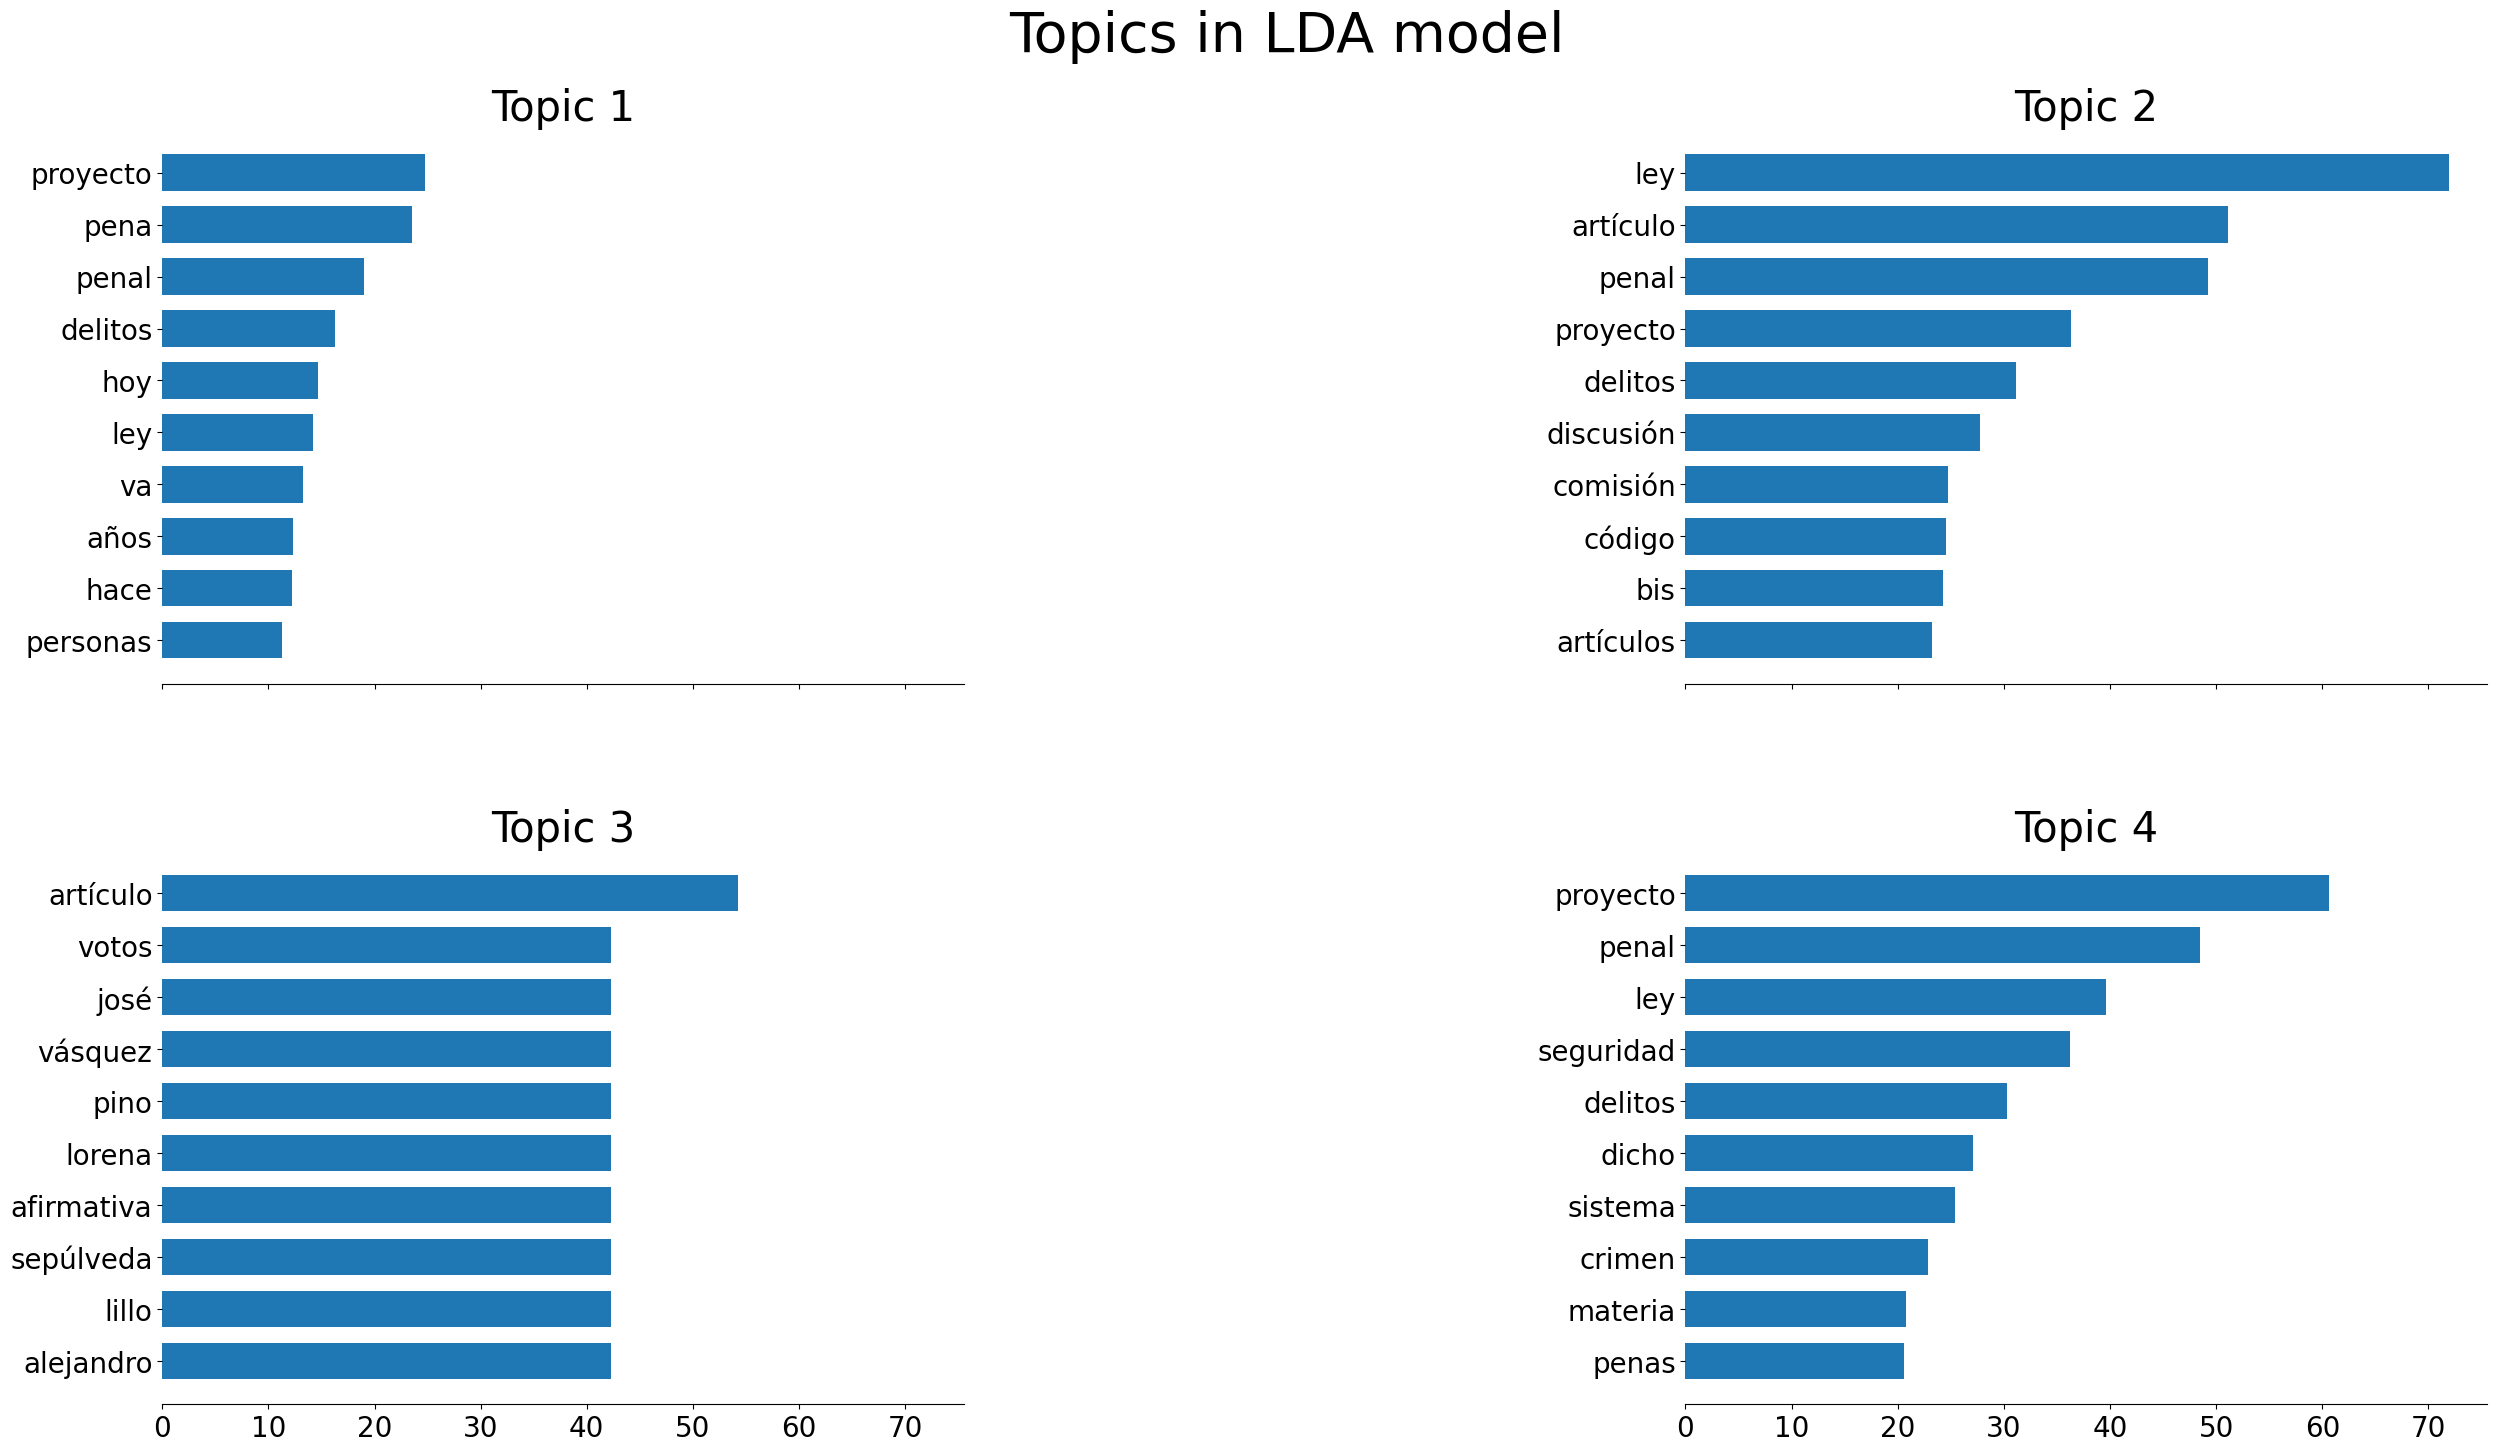

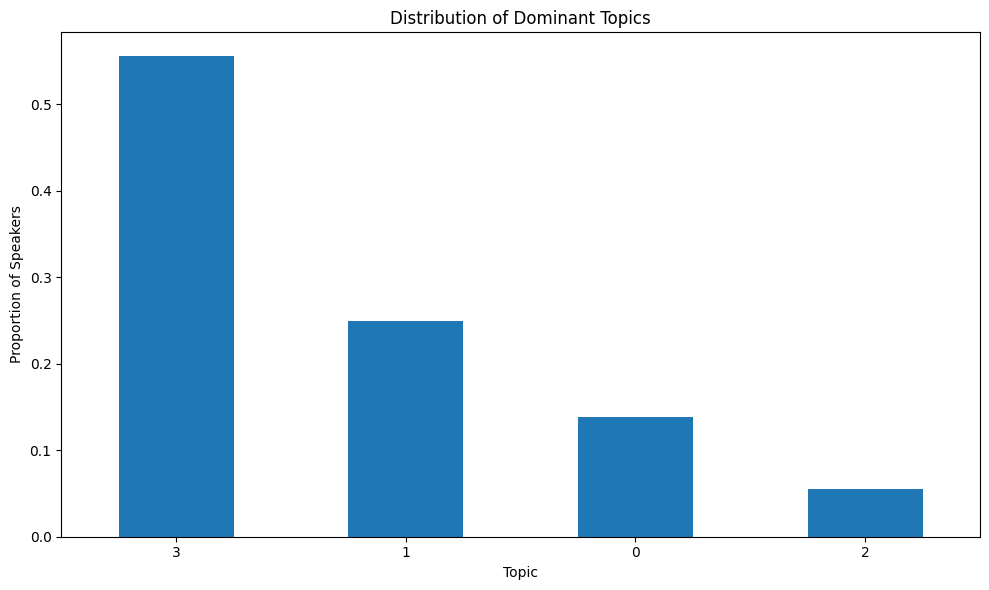

In [17]:
# Download Spanish stopwords
nltk.download('stopwords', quiet=True)

# Read the CSV file
df = pd.read_csv("extracted_speeches.csv")

# Get Spanish stop words and add more names/common words
additional_stop_words = set([
    'jorge', 'diputado', 'juan', 'palabra', 'maría', 'martínez', 'jaime', 'miguel', 'castro', 'pérez',
    'señor', 'señora', 'gonzález', 'andrés', 'muñoz', 'castillo', 'luis', 'araya', 'sáez', 'moreno',
    'romero', 'votación', 'camila', 'soto', 'salazar', 'salinas', 'daniel', 'ramírez', 'cristián',
    'antonio', 'leiva', 'sánchez', 'raúl', 'undurraga', 'guzmán', 'francisco', 'felipe', 'venegas',
    'marta', 'ángel', 'riquelme', 'alberto', 'bravo', 'mellado', 'emilia', 'ana', 'tomás', 'eduardo',
    'cristóbal', 'videla', 'gonzalo', 'maldonado', 'catalina', 'carlos', 'espinoza', 'palma', 'olea',
    'durán', 'valderrama', 'flores', 'vergara', 'félix', 'héctor', 'rojas', 'diputada', 'diputado',
    'vicepresidenta', 'vicepresidente', 'presidente', "quiero", "decir"
])
spanish_stop_words = set(stopwords.words('spanish')).union(additional_stop_words)

# Text Preprocessing Function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove single characters
    text = re.sub(r'\b[a-zA-Z]\b', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing to speeches
df['Processed_Speech'] = df['Speech'].apply(preprocess_text)

# Combine all speeches into a single document for each speaker
df_combined = df.groupby('Speaker')['Processed_Speech'].apply(' '.join).reset_index()

# Create Document-Term Matrix with bigrams
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=list(spanish_stop_words), ngram_range=(1,2))
doc_term_matrix = vectorizer.fit_transform(df_combined['Processed_Speech'])

# Create and fit the LDA model
lda_model = LatentDirichletAllocation(n_components=4, random_state=42, max_iter=100)
lda_output = lda_model.fit_transform(doc_term_matrix)

# Function to print top words for each topic
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

# Print the top 10 words for each topic
print("\nTop 10 words for each topic:")
print_topics(lda_model, vectorizer.get_feature_names_out(), 10)

# Assign the dominant topic to each speaker
df_combined['Dominant_Topic'] = lda_output.argmax(axis=1)

# Print distribution of topics
topic_distribution = df_combined['Dominant_Topic'].value_counts(normalize=True)
print("\nTopic Distribution:")
print(topic_distribution)

# Print speakers and their dominant topics
# print("\nSpeakers and their dominant topics:")
# for _, row in df_combined.iterrows():
#    print(f"Speaker: {row['Speaker']}")
#    print(f"Dominant Topic: Topic {row['Dominant_Topic'] + 1}")
#    print()

# Visualize the top n keywords for each topic
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 2, figsize=(30,15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx+1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda_model, vectorizer.get_feature_names_out(), 10, 'Topics in LDA model')

# Visualize topic distribution
plt.figure(figsize=(10, 6))
topic_distribution.plot(kind='bar')
plt.title('Distribution of Dominant Topics')
plt.xlabel('Topic')
plt.ylabel('Proportion of Speakers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Name Entity Recognition and Sentiment Analysis

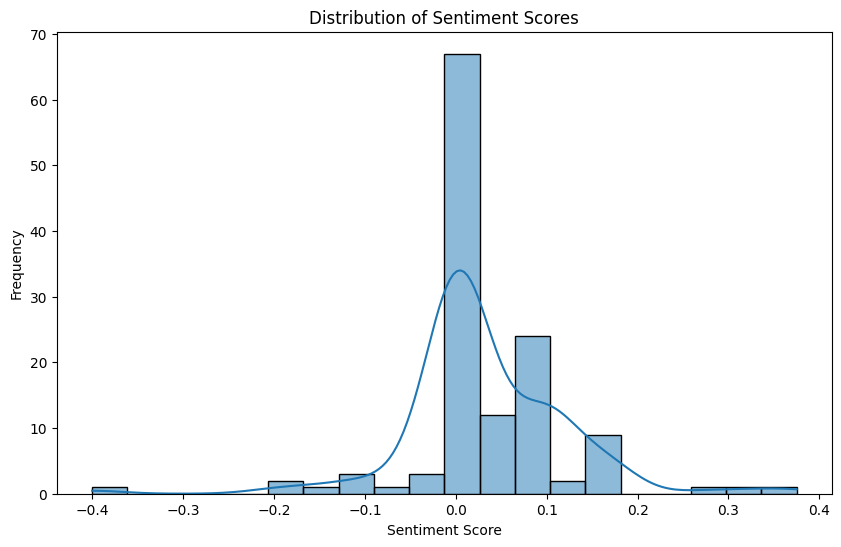

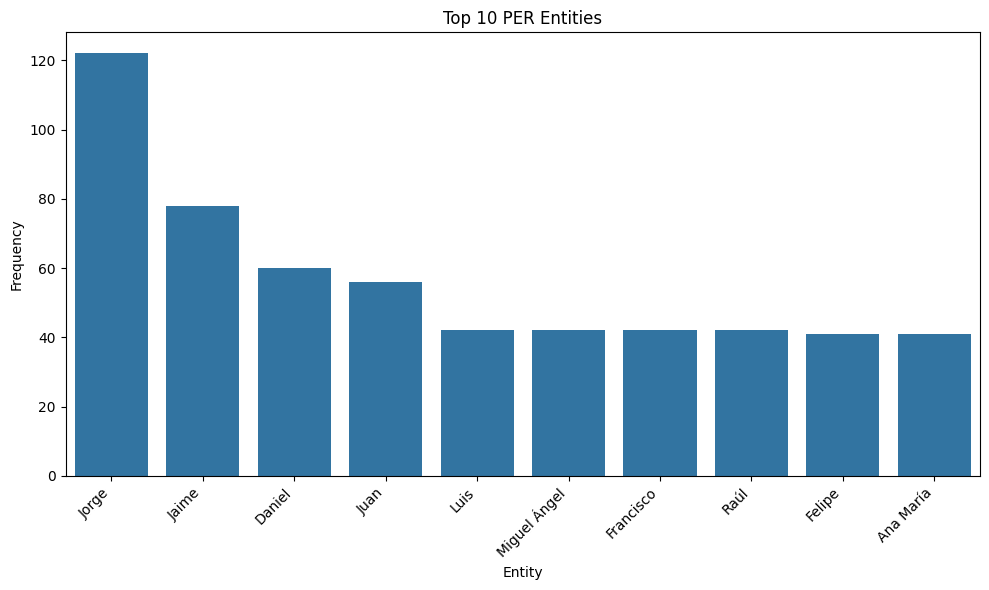

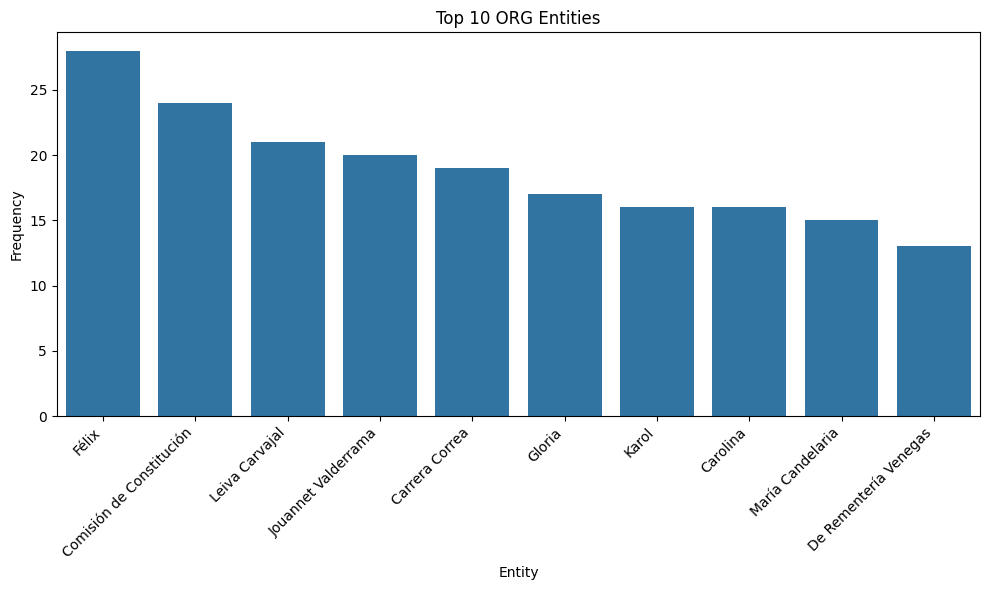

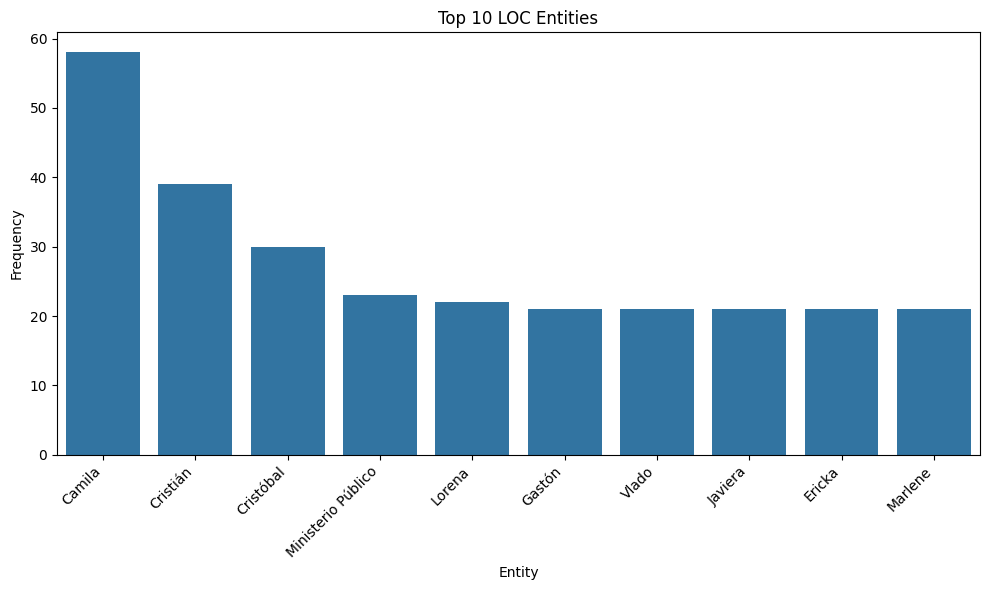

Analysis complete. Results saved to 'analyzed_speeches.csv' and visualization images.


In [18]:
# Load Spanish language model
nlp = spacy.load("es_core_news_sm")
nlp.add_pipe("spacytextblob")

def analyze_speech(text):
    doc = nlp(text)

    # Sentiment Analysis
    sentiment = doc._.blob.polarity

    # Named Entity Recognition
    entities = {
        'PER': [],
        'ORG': [],
        'LOC': []
    }
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_].append(ent.text)

    return sentiment, entities

def process_speeches(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Apply analysis to each speech
    results = df['Speech'].apply(analyze_speech)

    # Split results into separate columns
    df['Sentiment'] = results.apply(lambda x: x[0])
    df['Entities'] = results.apply(lambda x: x[1])

    return df

def visualize_sentiment(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Sentiment'], kde=True)
    plt.title('Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.savefig('sentiment_distribution.png')
    plt.show()
    plt.close()

def analyze_entities(df):
    all_entities = {'PER': [], 'ORG': [], 'LOC': []}
    for entities in df['Entities']:
        for key in all_entities:
            all_entities[key].extend(entities[key])

    for entity_type in all_entities:
        entity_counts = pd.Series(all_entities[entity_type]).value_counts().head(10)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=entity_counts.index, y=entity_counts.values)
        plt.title(f'Top 10 {entity_type} Entities')
        plt.xlabel('Entity')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f'top_{entity_type}_entities.png')
        plt.show()
        plt.close()

def main():
    file_path = '/content/extracted_speeches.csv'
    df = process_speeches(file_path)

    # Save processed data
    df.to_csv('analyzed_speeches.csv', index=False)

    # Visualize results
    visualize_sentiment(df)
    analyze_entities(df)

    print("Analysis complete. Results saved to 'analyzed_speeches.csv' and visualization images.")

if __name__ == "__main__":
    main()

## Term Frequency-Inverse Document Frequency

In [19]:
additional_stop_words = set([
    'jorge', 'diputado', 'juan', 'palabra', 'maría', 'martínez', 'jaime', 'miguel', 'castro', 'pérez',
    'señor', 'señora', 'gonzález', 'andrés', 'muñoz', 'castillo', 'luis', 'araya', 'sáez', 'moreno',
    'romero', 'votación', 'camila', 'soto', 'salazar', 'salinas', 'daniel', 'ramírez', 'cristián',
    'antonio', 'leiva', 'sánchez', 'raúl', 'undurraga', 'guzmán', 'francisco', 'felipe', 'venegas',
    'marta', 'ángel', 'riquelme', 'alberto', 'bravo', 'mellado', 'emilia', 'ana', 'tomás', 'eduardo',
    'cristóbal', 'videla', 'gonzalo', 'maldonado', 'catalina', 'carlos', 'espinoza', 'palma', 'olea',
    'durán', 'valderrama', 'flores', 'vergara', 'félix', 'héctor', 'rojas', 'diputada', 'diputado',
    'vicepresidenta', 'vicepresidente', 'presidente', "quiero", "decir"
])
spanish_stop_words = set(stopwords.words('spanish')).union(additional_stop_words)

# Calculate TF-IDF with stopwords
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=list(spanish_stop_words))
tfidf_matrix = tfidf_vectorizer.fit_transform(matched_speeches['Speech'])

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

def get_top_tfidf_words(tfidf_matrix, feature_names, top_n=10):
    sums = tfidf_matrix.sum(axis=0).A1
    term_scores = [(term, score) for term, score in zip(feature_names, sums)]
    term_scores = sorted(term_scores, key=lambda x: x[1], reverse=True)
    return term_scores[:top_n]

# Get top TF-IDF words overall
top_words = get_top_tfidf_words(tfidf_matrix, feature_names)
print("Top TF-IDF words overall:")
for word, score in top_words:
    print(f"{word}: {score}")

# Get top TF-IDF words by political category
for category in matched_speeches['Political Category'].unique():
    category_speeches = matched_speeches[matched_speeches['Political Category'] == category]
    category_tfidf = tfidf_vectorizer.transform(category_speeches['Speech'])
    top_words = get_top_tfidf_words(category_tfidf, feature_names)
    print(f"\nTop TF-IDF words for {category}:")
    for word, score in top_words:
        print(f"{word}: {score}")

Top TF-IDF words overall:
proyecto: 5.981642132343973
artículo: 5.0243842495580555
votos: 4.847183214953333
ley: 4.741031105639231
longton: 4.209452014163265
comisión: 4.087222319575186
penal: 3.823294664561902
discusión: 3.2655656619543194
indicación: 3.0936139107359426
sistema: 3.064696192383512

Top TF-IDF words for Alianza de Gobierno:
proyecto: 2.2375391731618226
ministro: 2.136470078241257
ley: 2.087077332590652
penal: 1.6498682997324687
discusión: 1.6381155367623932
longton: 1.1401779397840566
informante: 1.1348835182002097
artículo: 1.1127044763440606
delitos: 1.1083630368582467
leonardo: 1.0661153829344023

Top TF-IDF words for Center:
votos: 4.657508387791509
artículo: 3.6484807233517524
negativa: 2.6544019115117736
afirmativa: 2.6529774031667563
indicación: 2.563756889743993
comisión: 2.3893729806662707
dio: 2.366751674862707
económica: 2.366751674862707
efectuada: 2.366751674862707
resultado: 2.366751674862707

Top TF-IDF words for Center-Right:
penal: 0.7005595071148205
pe

In [19]:
# matched_speeches.columns

# Strengths and challenges

*   Me gustaría poder ofrecer varias leyes. Por ahora no se puede. Luego eso con Selenium se podría llegar a automatizar la obtención de datos y que el usuario solo tenga que escribir la ley que quiere estudiar y el tipo de análisis que quiere recibir.


Read a large PDF containing transcriptions of legislative sessions (e.g., the "Discusión en Sala" section), this pdf should have only the "Discusiones en Salas" because there is the information that it's relevant for the speech analysis. User can do this by only selecting "Discusiones en Sala"

For the analysis of deputies can I get a list of the votes of them?
With the text and the votes, can I make models out of them?